# Testing the High Dimensional VECM Model

This notebook demonstrates how to build, estimate, and validate the High Dimensional Vector Error Correction Model (VECM) using the implementation from our paper.  
We follow the workflow:
1. Import and initialize the model.
2. Build the required matrices.
3. Rank and Lag estimation
4. Estimating the other parameters.
5. Check model diagnostics and results.

The goal is to verify correctness of the implementation and illustrate its usage on synthetic or example data.

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from vecm_model_high_dim import VECMModelHD
from helpers import Helpers
from group_lasso_prox_lag import GroupLassoProxLagSelection
from group_lasso_prox_rank import GroupLassoProxRankSelection
from multinomial_logit_model import MultinomialLogit

This python notebook, will test the high vecm model, with parameter estimations from Section 3.4 of our paper.
We will start by reading in the data we gathered.

In [106]:
# This should be the path to the data_1.csv file on your local machine
PATH = "/Users/noah/Downloads/sol_spot_futures_data_kuma_sol.csv"

SKIP_ROWS = 0
N_ROWS = 50000
# The exchange names as hinted in footnote 1 of our paper
DF_NAMES = ['binance', 'bitmart', 'bybit', 'hashkey', 'htx', 'bitget', 'deribit', 'kuma', 'hyperliquid']

VECM_model_b = VECMModelHD()
VECM_model_a = VECMModelHD()
helper_methods = Helpers()

binance, bitmart, bybit, hashkey, htx, bitget, deribit, kuma, hyperliquid = helper_methods.read_csv_to_dataframe(PATH, SKIP_ROWS, N_ROWS, DF_NAMES)

Since the class VECMModelHD extends VECMModel, we can use all methods already defined in VECMModel, for example constructing Y

In [110]:
Y_b = VECM_model_b.construct_Y([binance.bids, bitmart.bids, bybit.bids, htx.bids, bitget.bids, deribit.bids, kuma.bids, hyperliquid.bids])
Y_a = VECM_model_a.construct_Y([binance.asks, bitmart.asks, bybit.asks, htx.asks, bitget.asks, deribit.asks, kuma.asks, hyperliquid.asks])

The variables of course also have to be I(1) for the high dim appraoch, we will check similar to the non high dim model

In [111]:
N = min(10000, Y_b.shape[1])

for idx in range(Y_b.shape[0]):
    time_series = np.diff(Y_b[idx][:N]) # The method adf_p_value drops nan (the frist value each itself)
    try:
        p_value = VECM_model_b.adf_p_value(time_series)
        if p_value <= 0.05:
            print(f"column {idx} is staionary after differencing")
        else:
            print(f"column {idx} is not staionary after differencing")

    except Exception as excp:
        print(excp)

column 0 is staionary after differencing
column 1 is staionary after differencing
column 2 is staionary after differencing
column 3 is staionary after differencing
column 4 is staionary after differencing
column 5 is staionary after differencing
column 6 is staionary after differencing
column 7 is staionary after differencing


In [112]:
# Same for the ask side

N = min(10000, Y_a.shape[1]) # We suggest not to choose N too large, or it will run very long

for idx in range(Y_a.shape[0]):
    time_series = np.diff(Y_a[idx][:N]) # The method adf_p_value drops nan (the frist value each itself)
    try:
        p_value = VECM_model_a.adf_p_value(time_series)
        if p_value <= 0.05:
            print(f"column {idx} is staionary after differencing")
        else:
            print(f"column {idx} is not staionary after differencing")

    except Exception as excp:
        print(excp)

column 0 is staionary after differencing
column 1 is staionary after differencing
column 2 is staionary after differencing
column 3 is staionary after differencing
column 4 is staionary after differencing
column 5 is staionary after differencing
column 6 is staionary after differencing
column 7 is staionary after differencing


Let's start with rank selection, given a VECM of the form in, we begin by removing the influence of the short-run components $ \Delta X^{(b)} $ from both $ \Delta Y^{(b)} $ and $ Y_{-1}^{(b)} $.  
This is achieved by applying the projection matrix:

$$
M_{\Delta X^{(b)}} = I_T - \Delta X^{(b)\top} \left( \Delta X^{(b)} \Delta X^{(b)\top} \right)^{-1} \Delta X^{(b)}.
$$

The transformed variables are:

$$
\Delta \widetilde{Y}^{(b)} = \Delta Y^{(b)} M_{\Delta X^{(b)}}, \quad
\widetilde{Y}_{-1}^{(b)} = Y_{-1}^{(b)} M_{\Delta X^{(b)}}, \quad
\widetilde{W}^{(b)} = [\widetilde{w}_1^{(b)}, \ldots, \widetilde{w}_T^{(b)}] = W^{(b)} M_{\Delta X^{(b)}}.
$$

Based on these transformations, the model can be rewritten in reduced form for cointegration rank selection:

$$
\Delta \widetilde{Y}^{(b)}_{t} = \alpha^{(b)} (\beta^{(b)})^{\top} \widetilde{Y}_{t-1}^{(b)} + \widetilde{w}^{(b)}_{t}, 
\quad t = 1, \ldots, T,
$$

where the short-run dynamics have been partialled out via projection, leaving only the long-run structure.

Here the error terms $ u_t^{(b)} $ are assumed to satisfy moment conditions, but no specific distributional assumptions are imposed.

We therefore choose $M \gg P$ as the lag. This refers to Section 3.4.1 of our paper.

In [113]:
M = 50

In [114]:
VECM_model_b.lag = M
VECM_model_a.lag = M

In [115]:
Y_train_b, Y_test_b = VECM_model_b.train_test_split_Y(Y_b, 0.7)
Y_train_a, Y_test_a = VECM_model_a.train_test_split_Y(Y_a, 0.7)

We also build the basic VECM matrices like in the non high dimensional model, from equation 3.2 in our paper.

$$
\Delta Y^{(b)} = \Pi^{(b)} Y_{-1}^{(b)} + \Gamma^{(b)} \Delta X^{(b)} + U^{(b)}
$$

where

$$
\Delta Y^{(b)} := \bigl[ \Delta y^{(b)}_{1}, \ldots, \Delta y^{(b)}_{T} \bigr],
$$

$$
Y_{-1}^{(b)} := \bigl[ y^{(b)}_{0}, \ldots, y^{(b)}_{T-1} \bigr],
$$

$$
\Gamma^{(b)} := \bigl[ \Gamma^{(b)}_{1}, \ldots, \Gamma^{(b)}_{p} \bigr],
$$

$$
\Delta X^{(b)} := \bigl[ \Delta X^{(b)}_{0}, \ldots, \Delta X^{(b)}_{T-1} \bigr],
\quad \text{with} \quad
\Delta X^{(b)}_{t-1} :=
\begin{bmatrix}
\Delta y^{(b)}_{t-1} \\
\vdots \\
\Delta y^{(b)}_{t-p}
\end{bmatrix},
$$

$$
U^{(b)} := \bigl[ u^{(b)}_{1}, \ldots, u^{(b)}_{T} \bigr].
$$

In [116]:
VECM_model_b.build_vecm_matrices(Y_train_b)
VECM_model_a.build_vecm_matrices(Y_train_a)

## Rank Selection

Based on these transformations, the model can be rewritten in reduced form for cointegration rank selection:

$$
\Delta \widetilde{Y}^{(b)}_{t} = \alpha^{(b)} (\beta^{(b)})^{\top} \widetilde{Y}_{t-1}^{(b)} + \widetilde{w}^{(b)}_{t}, 
\quad t = 1, \ldots, T,
$$

where the short-run dynamics have been partialled out via projection, leaving only the long-run structure.

Here the error terms $u_t^{(b)}$ are assumed to satisfy moment conditions, but no specific distributional assumptions are imposed.
The least-squares pre-estimate $\widetilde{\Pi}^{(b)}$ of the long-run matrix $\Pi^{(b)}$ based on the transformed model is given by:

$$
\widetilde{\Pi}^{(b)} 
= \left( \Delta Y^{(b)} M_{\Delta X^{(b)}} (Y_{-1}^{(b)})^\top \right) 
  \left( Y_{-1}^{(b)} M_{\Delta X^{(b)}} (Y_{-1}^{(b)})^\top \right)^{-1}.
$$

In [117]:
dY_tilde_b, Y1_tilde_b, Pi_tilde_b = VECM_model_b.frisch_waugh_rank_matrices()
dY_tilde_a, Y1_tilde_a, Pi_tilde_a = VECM_model_a.frisch_waugh_rank_matrices()

Next, a QR decomposition with column pivoting is applied to $(\widetilde{\Pi}^{(b)})^\top$:

$$
(\widetilde{\Pi}^{(b)})^{\top} = \widehat{Q}^{(b)} \widetilde{R}^{(b)},
$$

where $\widehat{Q}^{(b)} \in \mathbb{R}^{K \times K}$ is orthogonal and $\widetilde{R}^{(b)} \in \mathbb{R}^{K \times K}$ is upper triangular.

In [118]:
Q_hat_b, R_tilde_b, Perm_b = VECM_model_b.qr_decomp(Pi_tilde_b.T)
Q_hat_a, R_tilde_a, Perm_a = VECM_model_a.qr_decomp(Pi_tilde_a.T)

Pmat_b = np.eye(Perm_b.shape[0])[:, Perm_b]
Pmat_a = np.eye(Perm_a.shape[0])[:, Perm_a]

# Sanity checks
np.allclose(Pi_tilde_b.T, (Q_hat_b @ R_tilde_b @ Pmat_b.T)), np.allclose(Pi_tilde_a.T, (Q_hat_a @ R_tilde_a @ Pmat_a.T))

(True, True)

The adaptive weights $\widetilde{\mu}^{(b)}_m$ used in the penalty term are defined as and computed in the following:

$$
\widetilde{\mu}^{(b)}_m = \sqrt{ \sum_{j = m}^{K} \left( \widetilde{R}^{(b)}_{m,j} \right)^2 },
$$

where $m$ and $j$ denote specific row and column indices of the upper triangular matrix $\widetilde{R}^{(b)}$.  

These weights are further used in the pre-estimation of the cointegration rank. Based on them, it can be shown the adaptive group Lasso consistently recovers the true cointegration rank.

In [119]:
mu_tilde_b = VECM_model_b.compute_mu_tilde(R_tilde_b)
mu_tilde_a = VECM_model_a.compute_mu_tilde(R_tilde_a)

The pre-estimated cointegration rank is defined as:

$$
\tilde{r} = \sum_{j=1}^K \mathbb{1}\!\left\{ \,\tilde{\mu}_j > \epsilon \,\right\},
$$

where $\mathbb{1}\{\cdot\}$ denotes the indicator function and $\epsilon$ is a small threshold.

In [120]:
r_hat_qr_decomp_b = VECM_model_b.rank_pre_estimate(mu_tilde_b)
r_hat_qr_decomp_a = VECM_model_a.rank_pre_estimate(mu_tilde_a)

r_hat_qr_decomp_b, r_hat_qr_decomp_a

(np.int64(7), np.int64(7))

$\tilde{r}$ (r_hat_qr_decomp_b) serves as a pre-estimate of the cointegration rank, obtained from the QR decomposition of $\tilde{\Pi}^\top$.  
The corresponding cointegration vectors are then defined as:

$$
\beta^{(b)} := \widehat{Q}^{(b)}_{[:,\,1:\tilde{r}]},
$$

where $\widehat{Q}^{(b)}_{[:,\,1:\tilde{r}]}$ denotes the first $\tilde{r}$ columns of $\widehat{Q}^{(b)}$.

In [121]:
beta_b = VECM_model_b.get_beta(Q_hat_b, r_hat_qr_decomp_b)
beta_a = VECM_model_a.get_beta(Q_hat_a, r_hat_qr_decomp_a)

We need to rotate the data matrices accordingly

In [122]:
dY_tilde_b = Pmat_b.T @ dY_tilde_b
dY_tilde_a = Pmat_a.T @ dY_tilde_a

Y1_tilde_b = Pmat_b.T @ Y1_tilde_b
Y1_tilde_a = Pmat_a.T @ Y1_tilde_a

An estimate $\widehat{r}$ of the cointegration rank is obtained by counting the non-zero columns of $\widehat{R}^{(b)}$, 
where $\widehat{R}^{(b)}$ solves the following adaptive group Lasso problem:

$$
\sum_{t=1}^{T} \left\| \Delta \widetilde{Y}_t^{(b)} 
- (R^{(b)})^\top (\widehat{Q}^{(b)})^\top \widetilde{Y}_{t-1}^{(b)} \right\|_2^2 
+ \sum_{m=1}^{K} \frac{\tau^{rank}}{(\widetilde{\mu}_m^{(b)})^\gamma} 
\left\| (R^{(b)})^\top_{[:,m]} \right\|_2.
$$

The first term measures the squared prediction error, while the second term applies an adaptive group Lasso penalty 
to the columns of $(R^{(b)})^\top$, shrinking some of them towards zero.  

Thus, each column $(\widehat{R}^{(b)})^\top_{[:,m]}$ of the estimator minimizes the above objective for 
$m = 1, \dots, K$. The penalization parameter $\tau^{rank}$ and 
adaptiveness weight $\gamma$ are chosen in a data-driven, pre-specified manner.

The tuning parameter $\tau^{rank}$ is selected using a BIC-type criterion:

$$
\min_{\tau} \; \log \left| \widehat{\Sigma}_w(\tau) \right| 
+ \frac{\log T}{T} \; \left\| \mathrm{vec}(A(\tau)) \right\|_0,
$$

where $A = \widehat{R}(\tau)$ in rank selection and $A = \widehat{B}(\tau)$ in lag selection.  
Here, $\widehat{\Sigma}_w(\tau)$ denotes the sample covariance matrix of the residuals 
corresponding to the choice of $\tau$.  

The first term penalizes poor fit via the residual covariance, while the second term enforces sparsity 
in the parameter matrix through the $\ell_0$ norm of its vectorization.

In [67]:
# About solving the group lasso rank problem...

To estimate the high-dimensional lag and rank structures in the VECM, we solve the convex composite problem

$$
\min_{R}\;\; \ell(R) \;+\; \tau \sum_{m=1}^{M} w_m \,\|R_{[:,m]}\|_2,
\qquad
\ell(R) \;=\; \|\,Y - R^\top Z\,\|_F^2,
$$

where $Y$ are the residualized dependent stacked variables, $Z$ are the residualized regressors, $R$ is the coefficient matrix, $\tau>0$ is the penalty level, and $w_m>0$ are adaptive group weights.

Expanding $\ell(R)$ gives

$$
\ell(R) = \operatorname{tr}\!\big((Y - R^\top Z)(Y - R^\top Z)^\top\big)
= \operatorname{tr}(Y Y^\top) - 2\,\operatorname{tr}(Y Z^\top R) + \operatorname{tr}(R^\top Z Z^\top R).
$$

Differentiating with respect to $R$ yields the gradient

$$
\nabla \ell(R) = -\,2\,Z Y^\top + 2\, Z Z^\top R
= \underbrace{-\,2 Z Y^\top}_{\text{const\_term}} + \underbrace{2 Z Z^\top}_{\text{linear part}} R.
$$

Hence the gradient is $L$–Lipschitz with $L = 2\,\|Z Z^\top\|_2 = 2\,\lambda_{\max}(Z Z^\top)$. In practice we precompute $Z Z^\top$ and its largest eigenvalue and choose a fixed step size

$$
\eta = \frac{\text{offset}}{\lambda_{\max}(Z Z^\top)}, \quad \text{with } \text{offset}\in(0,1),
$$

which is conservative in applications (a stricter sufficient choice is $\eta \le 1/L$).

ISTA alternates a gradient step on the smooth part and a proximal step on the nonsmooth group penalty. With current iterate $R^{(k)}$,

$$
\widetilde{R}^{(k)} = R^{(k)} - \eta\,\nabla \ell\!\big(R^{(k)}\big)
= R^{(k)} - \eta\Big(\,-2 Z Y^\top + 2 Z Z^\top R^{(k)}\Big).
$$

The proximal operator of the $\ell_{2,1}$ penalty $\sum_m w_m\|R_{[:,m]}\|_2$ is block soft–thresholding, which acts columnwise:

$$
\operatorname{prox}_{\eta \tau \sum_m w_m \|\cdot\|_2}(\widetilde{R})_{[:,m]}
=
\begin{cases}
\Big(1 - \dfrac{\eta\,\tau\,w_m}{\|\widetilde{R}_{[:,m]}\|_2}\Big)\,\widetilde{R}_{[:,m]}, & \|\widetilde{R}_{[:,m]}\|_2 > \eta\,\tau\,w_m, \\[8pt]
0, & \text{otherwise}.
\end{cases}
$$

Equivalently, with a small numerical $\varepsilon>0$ to avoid division by zero,

$$
R^{(k+1)}_{[:,m]}
= \max\!\Big(0,\; 1 - \frac{\eta \tau w_m}{\|\widetilde{R}^{(k)}_{[:,m]}\|_2 + \varepsilon}\Big)\;\widetilde{R}^{(k)}_{[:,m]}
\quad \text{for } m=1,\dots,M.
$$

This matches the vectorized implementation: compute $\widetilde{R}^{(k)}$, take column norms, form the scaling factors $\max\!\big(0, 1 - (\eta\tau w_m)/\|\cdot\|_2\big)$, and rescale columns.

We initialize at $R^{(0)}=R_{\text{init}}$, precompute $\text{const\_term}=-2 Z Y^\top$ and $Z Z^\top$, and set $\eta$ from $\lambda_{\max}(Z Z^\top)$. We stop when either the parameter change is small or the objective stabilizes:

$$
\|R^{(k+1)} - R^{(k)}\|_F < \text{tol}
\quad\text{or}\quad
\frac{|\mathcal{J}(R^{(k+1)}) - \mathcal{J}(R^{(k)})|}{\max\{1,|\mathcal{J}(R^{(k)})|\}} < \text{tol},
$$

where $\mathcal{J}(R)=\ell(R)+\tau \sum_m w_m \|R_{[:,m]}\|_2$.


One can accelerate ISTA with Nesterov momentum (FISTA). Starting with $t_0=1$ and an auxiliary variable $U^{(0)}=R^{(0)}$, each iteration performs

$$
R^{(k+1)} = \operatorname{prox}_{\eta \tau \sum_m w_m \|\cdot\|_2}\!\Big(U^{(k)} - \eta\,\nabla \ell(U^{(k)})\Big),
$$

$$
t_{k+1} = \frac{1+\sqrt{1+4 t_k^2}}{2},
$$

$$
U^{(k+1)} = R^{(k+1)} + \frac{t_k-1}{t_{k+1}}\big(R^{(k+1)} - R^{(k)}\big).
$$

We use a monotone safeguard: if the objective increases, we reset the momentum by taking $U^{(k+1)} \leftarrow R^{(k+1)}$ and $t_{k+1}\leftarrow 1$.

In [123]:
group_lasso_prox_rank_b = GroupLassoProxRankSelection()
group_lasso_prox_rank_a = GroupLassoProxRankSelection()

In [124]:
tau_ranks_b = [1e10]#[10.0**p for p in np.arange(-20, 20, 1)]

T = VECM_model_b.T_eff
K = VECM_model_b.K

gamma = 2
bic_criterion_score_rank_b = {}

weights = group_lasso_prox_rank_b.compute_weights(mu_tilde_b, gamma)
weights = group_lasso_prox_rank_b.scale_weights(weights)
Y, Z = group_lasso_prox_rank_b.construct_Y_Z_matrices(Q_hat_b, Y1_tilde_b, dY_tilde_b)

for tau_rank_b in tau_ranks_b:
    R_hat_b, loss_history = group_lasso_prox_rank_b.fit(R_tilde_b, Y, Z, tau_rank_b, weights, tol = 1e-20)

    Sigma_w_b = VECM_model_b.residual_covariance(dY_tilde_b, R_hat_b.T @ Q_hat_b.T @ Y1_tilde_b)
    bic_criterion_score_rank_b[tau_rank_b] = VECM_model_b.bic_criterion(Sigma_w_b, R_hat_b)

In [125]:
R_hat_b

array([[ 1.37863822e-01,  1.04016736e-02, -5.06859640e-03,
        -4.74418686e-03, -2.87317485e-02,  1.55421449e-02,
         4.36406598e-03, -0.00000000e+00],
       [ 5.97728990e-08,  3.41128518e-02, -6.23669204e-04,
        -2.55467628e-03,  6.22214065e-03, -2.33713502e-02,
        -1.44153705e-02, -0.00000000e+00],
       [ 2.94784824e-08,  1.35249750e-08,  2.34859953e-02,
        -6.92806967e-04, -1.16224492e-02,  5.94459209e-03,
         6.25668166e-03,  0.00000000e+00],
       [-1.00765500e-08,  2.95712036e-09, -5.09970137e-09,
         2.15066067e-02,  8.27834333e-03,  1.18897308e-02,
        -9.76239211e-04,  0.00000000e+00],
       [ 6.51340229e-08, -1.70479144e-08,  8.35708526e-10,
         1.59062094e-08, -1.53773710e-02, -1.15613348e-03,
         5.46774065e-03, -0.00000000e+00],
       [ 1.14895432e-07, -8.58360249e-09, -1.09168263e-08,
        -3.77956640e-09, -1.81692320e-08,  8.53846746e-03,
         2.64676428e-03, -0.00000000e+00],
       [-8.54681989e-09,  6.793715

In [126]:
np.linalg.matrix_rank(R_hat_b, tol = 1e-10)

np.int64(7)

In [127]:
helper_methods.argmin_dict_value(bic_criterion_score_rank_b)

10000000000.0

Same is done for the ask side

In [128]:
tau_ranks_a = [1e10]#[10.0**p for p in np.arange(-20, 20, 1)]

T = VECM_model_a.T_eff
K = VECM_model_a.K

gamma = 2
bic_criterion_score_rank_a = {} 
group_lasso_prox_rank_a = GroupLassoProxRankSelection()
weights = group_lasso_prox_rank_a.compute_weights(mu_tilde_a, gamma)
weights = group_lasso_prox_rank_a.scale_weights(weights)
Y, Z = group_lasso_prox_rank_a.construct_Y_Z_matrices(Q_hat_a, Y1_tilde_a, dY_tilde_a)
for tau_rank_a in tau_ranks_a:  
    R_hat_a, loss_history = group_lasso_prox_rank_a.fit(R_tilde_a, Y, Z, tau_rank_a, weights, tol = 1e-20)

    Sigma_w_a = VECM_model_a.residual_covariance(dY_tilde_a, R_hat_a.T @ Q_hat_a.T @ Y1_tilde_a)
    bic_criterion_score_rank_a[tau_rank_a] = VECM_model_a.bic_criterion(Sigma_w_a, R_hat_a)

In [129]:
R_hat_a

array([[-2.15532791e-01,  1.27462405e-03, -4.48864125e-03,
         1.97718492e-02, -3.64457216e-02,  1.12664984e-02,
         1.67178739e-02,  0.00000000e+00],
       [-1.96285225e-07, -3.64561611e-02,  2.00210278e-03,
         1.12365794e-02,  4.51745449e-03,  8.21692960e-03,
         1.94173346e-02,  0.00000000e+00],
       [-1.70931064e-07,  1.42834047e-08,  2.12376667e-02,
        -5.61810207e-03,  1.49038458e-02, -9.12117977e-04,
         1.06452724e-02, -0.00000000e+00],
       [ 3.64157463e-09,  7.78743560e-09,  3.41602544e-09,
         1.82462079e-02, -2.39617427e-03, -5.90983366e-03,
        -2.35355408e-03,  0.00000000e+00],
       [ 7.75195165e-08,  3.26576458e-09,  3.24363300e-08,
        -2.02764853e-08, -1.18784758e-02,  2.72814268e-03,
        -8.15821688e-03, -0.00000000e+00],
       [ 1.45275312e-07, -2.83411053e-08,  2.10482653e-08,
        -4.67261917e-09,  4.18302819e-08, -7.50524407e-03,
        -3.44351221e-03,  0.00000000e+00],
       [-9.78080117e-08,  8.176336

In [130]:
np.linalg.matrix_rank(R_hat_a, tol = 1e-10)

np.int64(7)

In [131]:
helper_methods.argmin_dict_value(bic_criterion_score_rank_a)

10000000000.0

In [132]:
# Set rank
VECM_model_b.rank = 7
VECM_model_a.rank = 7

The loading matrix $\alpha^{(b)}$ is extracted from the QR decomposition with column pivoting, 
together with the permutation matrix from the group lasso solution.  

Given:
- $P^{(b)}$ = permutation matrix from the pivoted QR decomposition,  
- $\widehat{R}^{(b)}$ = upper triangular $R$ matrix from the group lasso estimation,  
- $\tilde{r}$ (denoted `r_hat_qr_decomp_b`) = estimated cointegration rank,  

the estimator of $\alpha^{(b)}$ is computed as

$$
\widehat{\alpha}^{(b)} \;=\; P^{(b)} \cdot \widehat{R}^{(b)\top}_{[:,1:\tilde{r}]} ,
$$

where $\widehat{R}^{(b)\top}_{[:,1:\tilde{r}]}$ denotes the first $\tilde{r}$ columns of the transpose of $\widehat{R}^{(b)}$.  

The permutation matrix $P^{(b)}$ ensures that the original column ordering is respected,  
while the truncated factor $\widehat{R}^{(b)\top}_{[:,1:\tilde{r}]}$ selects the components corresponding 
to the estimated cointegration rank $\tilde{r}$.

In [133]:
alpha_b = VECM_model_b.get_alpha(Pmat_b, R_hat_b, r_hat_qr_decomp_b)
alpha_a = VECM_model_a.get_alpha(Pmat_a, R_hat_a, r_hat_qr_decomp_a)

In [134]:
alpha_b.shape, beta_b.shape, np.linalg.matrix_rank(alpha_b @ beta_b.T)

((8, 7), (8, 7), np.int64(7))

Sanity check matrix rank

In [135]:
# Check if the group lasso reduced the rank when choosing the same tolerance
np.linalg.matrix_rank(R_hat_b, tol = 1e-10), np.linalg.matrix_rank(R_tilde_b, tol = 1e-10), np.linalg.matrix_rank(R_hat_a, tol = 1e-10), np.linalg.matrix_rank(R_tilde_a, tol = 1e-10)

(np.int64(7), np.int64(8), np.int64(7), np.int64(8))

## Lag Selection

We adopt a Frisch–Waugh-type transformation to isolate the lag structure within the VECM framework.  

To remove the nonstationary influence of $Y_{-1}^{(b)}$, the VECM is transformed using the projection matrix

$$
C_{Y_{-1}^{(b)}} \;=\; I_T \;-\; Y_{-1}^{(b)} \left( (Y_{-1}^{(b)})^{\top} Y_{-1}^{(b)} \right)^{-1} (Y_{-1}^{(b)})^{\top}.
$$

We then define the transformed variables as

$$
\check{Y}^{(b)} = \Delta Y^{(b)} C_{Y_{-1}^{(b)}}, \qquad
\check{X}^{(b)} = \Delta X^{(b)} C_{Y_{-1}^{(b)}},
$$

and let 

$$
\Gamma^{(b)} = \big(\Gamma_1^{(b)}, \ldots, \Gamma_{M}^{(b)}\big) \in \mathbb{R}^{K \times KM}
$$

denote the stacked matrix of lag coefficient matrices up to lag $M$.  

The transformed VECM model for lag selection is then given by

$$
\Delta \check{Y}_{t}^{(b)} \;=\; B^{(b)} \, \Delta \check{X}_{t-1}^{(b)} + \check{w}_t^{(b)}, 
\quad t = 1, \ldots, T,
$$

where 

$$
\check{W}^{(b)} = [\check{w}_1^{(b)}, \ldots, \check{w}_T^{(b)}] = W^{(b)} C_{Y_{-1}^{(b)}}.
$$

In [136]:
dY_check_b, dX_check_b = VECM_model_b.frisch_waugh_lag_matrices()
dY_check_a, dX_check_a = VECM_model_a.frisch_waugh_lag_matrices()

We obtain the least-squares estimator $\check{\Gamma}^{(b)}$ and the ridge estimator $\widetilde{\Gamma}^{(b)}$  
of the transient lag components $\Gamma^{(b)}$ from the transformed model as follows:

$$
\check{\Gamma}^{(b)} 
= \left( \frac{1}{T} \sum_{t=1}^T 
    \Delta \check{Y}_{t}^{(b)} \, \Delta \check{X}_{t-1}^{(b)\top} \right) 
  \left( \frac{1}{T} \sum_{t=1}^T 
    \Delta \check{X}_{t-1}^{(b)} \, \Delta \check{X}_{t-1}^{(b)\top} \right)^{-1},
$$

$$
\widetilde{\Gamma}^{(b)} 
= \left( \frac{1}{T} \sum_{t=1}^T 
    \Delta \check{Y}_{t}^{(b)} \, \Delta \check{X}_{t-1}^{(b)\top} \right)
  \left( \frac{1}{T} \sum_{t=1}^T 
    \Delta \check{X}_{t-1}^{(b)} \, \Delta \check{X}_{t-1}^{(b)\top} 
    + \frac{\tau^{ridge}}{T} I_{KM} \right)^{-1}.
$$

Here, the identity matrix $I_{KM} \in \mathbb{R}^{KM \times KM}$ ensures that ridge regularization  
is applied uniformly across all $M$ lag blocks, each of dimension $K$.  

In [137]:
Gamma_check_b = VECM_model_b.least_squares_estimate_Gamma(dX_check_b, dY_check_b)
Gamma_check_a = VECM_model_a.least_squares_estimate_Gamma(dX_check_a, dY_check_a)

In [138]:
T = VECM_model_b.T_eff # or VECM_model_a._T_eff, they have to align either way

# adjust these based on the numerical stability
c_b = 1
c_a = 1

tau_ridge_b = c_b * np.log(T)
tau_ridge_a = c_a * np.log(T)

Gamma_tilde_b = VECM_model_b.ridge_estimator_Gamma(dX_check_b, dY_check_b, tau_ridge_b, M)
Gamma_tilde_a = VECM_model_a.ridge_estimator_Gamma(dX_check_a, dY_check_a, tau_ridge_a, M)

The adaptive Lasso estimate 

$$
\widehat{\Gamma}^{(b)} = \big( \widehat{\Gamma}_1^{(b)}, \ldots, \widehat{\Gamma}_M^{(b)} \big)
$$ 

of the lag coefficient matrices is obtained by minimizing the objective

$$
\sum_{t=1}^T 
\left\| \Delta \check{Y}_t^{(b)} - \sum_{j=1}^M \Gamma_j^{(b)} \, \Delta \check{Y}_{t-j}^{(b)} \right\|_2^2 
\;+\; \tau^{\text{lag}} \sum_{j=1}^M 
    \big\| \text{vec}(\widetilde{\Gamma}_j^{(b)}) \big\|_\infty^{-\gamma} 
    \, \big\| \Gamma_j^{(b)} \big\|_F,
$$

where the second term applies an **adaptive group Lasso penalty**.  
The weights are derived from the ridge pre-estimate $\widetilde{\Gamma}^{(b)}$, ensuring that  
penalization adapts to the relative importance of each lag.  
This encourages **group-level sparsity** (i.e., entire lag matrices may be set to zero) while retaining  
lags that are estimated to be more influential.  

In [84]:
# About solving the group lasso lag problem...

To estimate the high-dimensional lag structure in the VECM, we solve the convex composite problem

$$
\min_{\Gamma}\;\; \ell(\Gamma) \;+\; \tau^{\text{lag}} \sum_{j=1}^{p} w_j \,\|\Gamma_j\|_F,
\qquad
\ell(\Gamma) \;=\; \|Y - \Gamma Z\|_F^2,
$$

where $Y$ are the residualized dependent stacked variables,
$Z$ are the stacked lagged regressors,  
$\Gamma = [\Gamma_1 \,|\, \dots \,|\, \Gamma_p]$ is the stacked lag coefficient matrix,  
$\tau^{\text{lag}}>0$ is the penalty level, and $w_j>0$ are adaptive block weights.  

---

Expanding $\ell(\Gamma)$ gives

$$
\ell(\Gamma) = \operatorname{tr}\!\big((Y - \Gamma Z)(Y - \Gamma Z)^\top\big)
= \operatorname{tr}(Y Y^\top) - 2\,\operatorname{tr}(Y Z^\top \Gamma^\top) + \operatorname{tr}(\Gamma Z Z^\top \Gamma^\top).
$$

Differentiating with respect to $\Gamma$ yields the gradient

$$
\nabla \ell(\Gamma) = -\,2\,Y Z^\top + 2\,\Gamma (Z Z^\top)
= \underbrace{-\,2 Y Z^\top}_{\text{const\_term}} + \underbrace{2(Z Z^\top)}_{\text{linear part}} \Gamma.
$$

Hence the gradient is $L$–Lipschitz with

$$
L = 2\,\|Z Z^\top\|_2 = 2\,\lambda_{\max}(Z Z^\top).
$$

In practice we precompute $Z Z^\top$ and its largest eigenvalue and choose a fixed step size

$$
\eta = \frac{\text{offset}}{\lambda_{\max}(Z Z^\top)}, 
\qquad \text{with } \text{offset}\in(0,1).
$$

---

### ISTA updates

ISTA alternates a gradient step on the smooth part and a proximal step on the nonsmooth group penalty.  
With current iterate $\Gamma^{(k)}$,

$$
\widetilde{\Gamma}^{(k)} = \Gamma^{(k)} - \eta\,\nabla \ell\!\big(\Gamma^{(k)}\big)
= \Gamma^{(k)} - \eta\Big(-2\,Y Z^\top + 2\,\Gamma^{(k)} Z Z^\top\Big).
$$

The proximal operator of the block $\ell_{2,1}$ penalty $\sum_j w_j\|\Gamma_j\|_F$ is block soft–thresholding, which acts groupwise on lag blocks:

$$
\operatorname{prox}_{\eta \tau^{\text{lag}} \sum_j w_j \|\cdot\|_F}(\widetilde{\Gamma})_{j}
=
\begin{cases}
\Big(1 - \dfrac{\eta\,\tau^{\text{lag}}\,w_j}{\|\widetilde{\Gamma}_j\|_F}\Big)\,\widetilde{\Gamma}_j, & \|\widetilde{\Gamma}_j\|_F > \eta\,\tau^{\text{lag}}\,w_j, \\[8pt]
0, & \text{otherwise}.
\end{cases}
$$

Equivalently, with a small numerical $\varepsilon>0$ to avoid division by zero,

$$
\Gamma^{(k+1)}_{j}
= \max\!\Big(0,\; 1 - \frac{\eta \tau^{\text{lag}} w_j}{\|\widetilde{\Gamma}^{(k)}_j\|_F + \varepsilon}\Big)\;\widetilde{\Gamma}^{(k)}_j
\quad \text{for } j=1,\dots,p.
$$

This matches the vectorized implementation: compute $\widetilde{\Gamma}^{(k)}$, take Frobenius norms of each block, form scaling factors $\max(0,1 - (\eta \tau^{\text{lag}} w_j)/\|\cdot\|_F)$, and rescale blocks.

---

### Stopping rule

We initialize at $\Gamma^{(0)}=\Gamma_{\text{init}}$, precompute $\text{const\_term}=-2 Y Z^\top$ and $Z Z^\top$, and set $\eta$ from $\lambda_{\max}(Z Z^\top)$.  

We stop when either the parameter change is small or the objective stabilizes:

$$
\|\Gamma^{(k+1)} - \Gamma^{(k)}\|_F < \text{tol}
\quad\text{or}\quad
\frac{|\mathcal{J}(\Gamma^{(k+1)}) - \mathcal{J}(\Gamma^{(k)})|}{\max\{1,|\mathcal{J}(\Gamma^{(k)})|\}} < \text{tol},
$$

where

$$
\mathcal{J}(\Gamma)=\ell(\Gamma)+\tau^{\text{lag}} \sum_j w_j \|\Gamma_j\|_F.
$$

---

### FISTA acceleration

We can accelerate ISTA with Nesterov momentum (FISTA). Starting with $t_0=1$ and $U^{(0)}=\Gamma^{(0)}$, each iteration performs

$$
\Gamma^{(k+1)} = \operatorname{prox}_{\eta \tau^{\text{lag}} \sum_j w_j \|\cdot\|_F}\!\Big(U^{(k)} - \eta\,\nabla \ell(U^{(k)})\Big),
$$

$$
t_{k+1} = \frac{1+\sqrt{1+4 t_k^2}}{2},
$$

$$
U^{(k+1)} = \Gamma^{(k+1)} + \frac{t_k-1}{t_{k+1}}\big(\Gamma^{(k+1)} - \Gamma^{(k)}\big).
$$

We use a monotone safeguard: if the objective increases, we reset the momentum by taking $U^{(k+1)} \leftarrow \Gamma^{(k+1)}$ and $t_{k+1}\leftarrow 1$.

In [139]:
tau_lag_b_candidates = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
bic_criterion_score_lag_b = {}
gamma = 2

group_lasso_prox = GroupLassoProxLagSelection()
K = VECM_model_b.K

weights = group_lasso_prox.compute_weights(Gamma_tilde_b, M, K, gamma)
weights = group_lasso_prox.scale_weights(weights)
Y, Z = group_lasso_prox.helper_loss(M, dY_check_b)

Gamma_hat_bs = []

for tau_lag_b in tau_lag_b_candidates:
    Gamma_hat_b, loss_history = group_lasso_prox.fit(Gamma_tilde_b, Y, Z, M, K, tau_lag_b, weights)
    Sigma_w_b = VECM_model_b.residual_covariance(dY_check_b, Gamma_hat_b @ dX_check_b)
    bic_criterion_score_lag_b[tau_lag_b] = VECM_model_b.bic_criterion(Sigma_w_b, Gamma_hat_b)

    Gamma_hat_bs.append(Gamma_hat_b)

In [140]:
tau_lag_a_candidates = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
bic_criterion_score_lag_a = {}      
gamma = 2

group_lasso_prox = GroupLassoProxLagSelection()
K = VECM_model_a.K

weights = group_lasso_prox.compute_weights(Gamma_tilde_a, M, K, gamma)
weights = group_lasso_prox.scale_weights(weights)
Y, Z = group_lasso_prox.helper_loss(M, dY_check_a)

Gamma_hat_as = []

for tau_lag_a in tau_lag_a_candidates:
    Gamma_hat_a, loss_history = group_lasso_prox.fit(Gamma_tilde_a, Y, Z, M, K, tau_lag_a, weights)
    Sigma_w_a = VECM_model_a.residual_covariance(dY_check_a, Gamma_hat_a @ dX_check_a)
    bic_criterion_score_lag_a[tau_lag_a] = VECM_model_a.bic_criterion(Sigma_w_a, Gamma_hat_a)

    Gamma_hat_as.append(Gamma_hat_a)

In [141]:
helper_methods.argmin_dict_value(bic_criterion_score_lag_b), helper_methods.argmin_dict_value(bic_criterion_score_lag_a)

(10000, 100000)

As one can observe in the following, shrinking the last columns to 0 wont work every time, since the norms of the blocks of $\widetilde{\Gamma}^{(b)}$ are already not converging to 0, so how should the group lasso then do it? Thats why one might need to choose the lag by looking at the plot, for example pick the first lag at wich the norm of a lag block is 0.

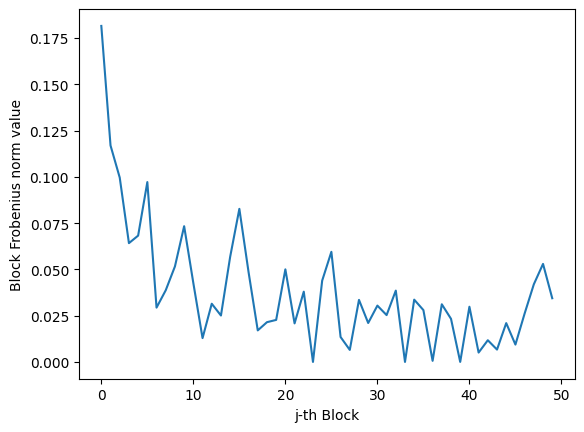

In [145]:
norms, optimal_lag_b, _ = VECM_model_b.select_lag_from_blocks(Gamma_hat_bs[7], M, eps = 0.125)

plt.plot(norms)
plt.xlabel("j-th Block")        # x-axis label
plt.ylabel("Block Frobenius norm value")   # y-axis label
plt.show()

#norms, optimal_lag_b, _ = VECM_model_b.select_lag_from_blocks(Gamma_tilde_b, M, eps = 0.125)
#plt.plot(norms); plt.show()

In [146]:
VECM_model_b.lag = 35
VECM_model_a.lag = 35

In [147]:
Gammas_b = Gamma_hat_bs[7][:, :VECM_model_b.lag*K]
Gammas_a = Gamma_hat_as[7][:, :VECM_model_a.lag*K]

$$
\Xi^{(b)} \;=\; \beta_{\perp}^{(b)} 
\Bigg[ \, (\alpha_{\perp}^{(b)})^{\top} 
\Bigg( I_K - \sum_{i=1}^{p} \Gamma_i^{(b)} \Bigg) 
\beta_{\perp}^{(b)} \,\Bigg]^{-1} 
(\alpha_{\perp}^{(b)})^{\top}.
$$

The matrix $\Xi^{(b)} \in \mathbb{R}^{K \times (K - r)}$ captures the contribution of the $K - r$ common stochastic trends,  
i.e., the nonstationary components driving the long-run dynamics of the system.  

If 
$$
(\alpha_{\perp}^{(b)})^{\top} 
\Bigg( I_K - \sum_{i=1}^{p} \Gamma_i^{(b)} \Bigg) 
\beta_{\perp}^{(b)}
$$ 
is invertible, then $\operatorname{rk}(\Xi^{(b)}) = K - r$.  

In the special case where there are $r = K - 1$ cointegration relationships,  
$\Xi^{(b)}$ has rank equal to $1$. This property will be exploited in the section on  
common trend components.

In [148]:
#

We now turn to the definition of the efficient latent price, making use of Eq. 4.36 and Eq. 4.42 from the paper.

Following Eq. 4.33, we define the $j$-th row vector containing the unscaled latent efficient price of the $j$-th variable, for the whole bid-side price vector, as

$$
\Lambda^{(b)} := \big( Y_{-1}^{(b)} \Xi^{(b)} \big)_j, 
\qquad j \in \{1, \ldots, K\}.
$$

Since this identification is only unique up to a nonsingular rotation, we need to scale $\Lambda^{(b)}$ in order to compare it to the observed price series of a particular exchange $\{y^{(b)}_{t,j}\}_{t=1}^T$ within $\{y^{(b)}_t\}_{t=1}^T$.  
The resulting scaled projection for the $j$-th exchange can then be interpreted as its latent efficient price.

We therefore define the unscaled common trend component associated with the $j$-th exchange (corresponding to the $j$-th entry of $y^{(b)}_t$) at time $t \in \{1, \ldots, T\}$ as

$$
\tilde{y}^{(b)}_{t,j} := \Lambda^{(b)}_t.
$$

---

To match the observed series $\{y^{(b)}_{t,j}\}_{t=1}^T$, we rescale $\{\tilde{y}^{(b)}_{t,j}\}_{t=1}^T$ by choosing a scalar $\phi^{(b)}_j \in \mathbb{R}$ that minimizes the squared $\ell_2$-distance. This yields the least squares problem

$$
\hat{\phi}^{(b)}_j := \arg\min_{\phi \in \mathbb{R}} \sum_{t=1}^T \left| y^{(b)}_{t,j} - \phi \tilde{y}^{(b)}_{t,j} \right|^2.
$$

The rescaled efficient price series is then

$$
\hat{y}^{(b)}_{t,j} := \hat{\phi}^{(b)}_j \, \tilde{y}^{(b)}_{t,j}, \quad t \in \{1, \ldots, T\}.
$$

---

To express this more compactly, define the vectors

$$
\mathbf{y}^{(b)}_j =
\begin{bmatrix}
y^{(b)}_{1j} \\
y^{(b)}_{2j} \\
\vdots \\
y^{(b)}_{Tj}
\end{bmatrix},
\qquad
\tilde{\mathbf{y}}^{(b)}_j =
\begin{bmatrix}
\tilde{y}^{(b)}_{1j} \\
\tilde{y}^{(b)}_{2j} \\
\vdots \\
\tilde{y}^{(b)}_{Tj}
\end{bmatrix},
$$

where both $\mathbf{y}^{(b)}_j$ and $\tilde{\mathbf{y}}^{(b)}_j$ lie in $\mathbb{R}^{T \times 1}$.

---

The least squares problem then becomes

$$
\hat{\phi}^{(b)}_j := \arg\min_{\phi \in \mathbb{R}} \big\| \mathbf{y}^{(b)}_j - \phi \tilde{\mathbf{y}}^{(b)}_j \big\|^2,
$$

which has the closed-form solution

$$
\hat{\phi}^{(b)}_j
= \left( (\tilde{\mathbf{y}}^{(b)}_j)^\top \tilde{\mathbf{y}}^{(b)}_j \right)^{-1}
  (\tilde{\mathbf{y}}^{(b)}_j)^\top \mathbf{y}^{(b)}_j
= \frac{ (\tilde{\mathbf{y}}^{(b)}_j)^\top \mathbf{y}^{(b)}_j }
       { \| \tilde{\mathbf{y}}^{(b)}_j \|^2 }.
$$

In [149]:
# Compute basis vectors for the orthogonal complements of alpha and beta for the bid and ask side respectively
alpha_perp_b = VECM_model_b.compute_null_space_basis(alpha_b.T)
beta_perp_b = VECM_model_b.compute_null_space_basis(beta_b.T)

alpha_perp_a = VECM_model_a.compute_null_space_basis(alpha_a.T)
beta_perp_a = VECM_model_a.compute_null_space_basis(beta_a.T)

In [150]:
Xi_b = VECM_model_b.compute_granger_representation_matrix_XI(alpha_perp_b, beta_perp_b, Gammas_b)
Xi_a = VECM_model_a.compute_granger_representation_matrix_XI(alpha_perp_a, beta_perp_a, Gammas_a)

In [174]:
# The variable we want to use to collect its fair price
j = 6 # < K

In [175]:
Lambda_b = (Xi_b @ Y_train_b)[j]
Lambda_a = (Xi_b @ Y_train_b)[j]

In [176]:
y_b = Y_train_b[j].T
y_breve_b = Lambda_b

y_a = Y_train_a[j].T
y_breve_a = Lambda_a

In [177]:
phi_b = VECM_model_b.estimate_phi(y_b, y_breve_b)
phi_a = VECM_model_a.estimate_phi(y_a, y_breve_a)

In [178]:
efficient_price_b = phi_b * (Xi_b @ Y_test_b)[j]
efficient_price_a = phi_a * (Xi_b @ Y_test_a)[j]

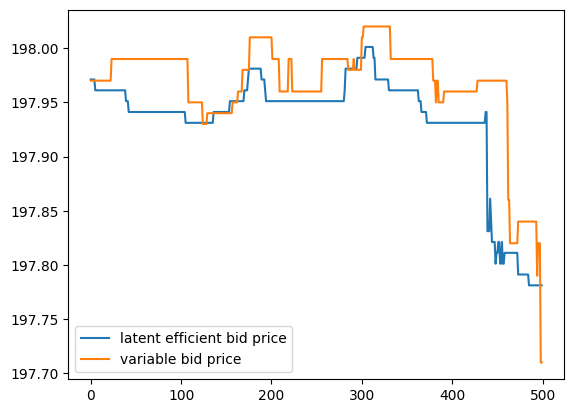

In [179]:
plt.plot(efficient_price_b[0:500], label = "latent efficient bid price")
plt.plot(Y_test_b[j][0:500], label = "variable bid price")
plt.legend()
plt.show()

In [180]:
# Compute basis vectors for the orthogonal complements of alpha and beta for the bid and ask side respectively
alpha_perp_b = VECM_model_b.compute_null_space_basis(alpha_b.T)
beta_perp_b = VECM_model_b.compute_null_space_basis(beta_b.T)

alpha_perp_a = VECM_model_a.compute_null_space_basis(alpha_a.T)
beta_perp_a = VECM_model_a.compute_null_space_basis(beta_a.T)

We now turn to Section 4.3 of our paper, where we introduce the $P$–$T$ decomposition of $y_t^{(b)}$, 
valid for $t \in \{1, \ldots, T\}$:

$$
y_t^{(b)} = A_1^{(b)} (\beta_\perp^{(b)})^\top y_t^{(b)} + A_2^{(b)} (\alpha^{(b)})^\top y_t^{(b)}.
\qquad (4.41)
$$

The matrices $A_1^{(b)}$ and $A_2^{(b)}$ are defined as

$$
A_1^{(b)} := \alpha_\perp^{(b)} \Big( (\beta_\perp^{(b)})^\top \alpha_\perp^{(b)} \Big)^{-1} 
\in \mathbb{R}^{K \times r},
\quad
A_2^{(b)} := \beta^{(b)} \Big( (\alpha^{(b)})^\top \beta^{(b)} \Big)^{-1} 
\in \mathbb{R}^{K \times (K-r)}.
$$

Here, $\alpha^{(b)}$ and $\beta^{(b)}$ are obtained from a fitted VECM, either as described in Sections 3.3 or 3.4 of our Paper.  
According to Engle and Granger (1987), this decomposition exists if  

$$
\det \!\left( (\alpha^{(b)})^\top \beta^{(b)} \right) \neq 0,
$$  

which ensures that the block matrix $\big( \beta_\perp^{(b)}, \alpha^{(b)} \big)$ is nonsingular.  

---

The representation in (4.41) satisfies two important properties:  

1. The common factors $(\beta_\perp^{(b)})^\top y_t^{(b)}$ are not cointegrated, meaning they do not share any stationary long-run relationships.  
2. The transitory component $(\alpha^{(b)})^\top y_t^{(b)}$ does not drive the permanent component $(\beta_\perp^{(b)})^\top y_t^{(b)}$ in the long run.  

Thus, short-run movements in $(\alpha^{(b)})^\top y_t^{(b)}$ have no predictive content for the long-run dynamics, which are governed entirely by the permanent part.  

These conditions mirror those typically imposed in factor analysis, where common factors are assumed to be mutually uncorrelated and orthogonal to the idiosyncratic components.  

---

Based on this decomposition, we define the **latent efficient bid price** as the permanent component of the $P$–$T$ decomposition, i.e. the part that excludes short-run transitory shocks. For each $t \in \{1, \ldots, T\}$ and variable $j \in \{1, \ldots, K\}$, it is given by

$$
\hat{y}_{t,j}^{(b)} :=  \big( A_1^{(b)} (\beta_\perp^{(b)})^\top y_t^{(b)} \big)_j.
\qquad (4.42)
$$

In [181]:
persistent_component_b_train, transitory_component_b_train = VECM_model_b.compute_P_T_decomposition(alpha_b, beta_b, alpha_perp_b, beta_perp_b, Y_train_b)
persistent_component_a_train, transitory_component_a_train = VECM_model_a.compute_P_T_decomposition(alpha_b, beta_b, alpha_perp_a, beta_perp_a, Y_train_a)

persistent_component_b_test, transitory_component_b_test = VECM_model_b.compute_P_T_decomposition(alpha_b, beta_b, alpha_perp_b, beta_perp_b, Y_test_b)
persistent_component_a_test, transitory_component_a_test = VECM_model_a.compute_P_T_decomposition(alpha_b, beta_b, alpha_perp_a, beta_perp_a, Y_test_a)

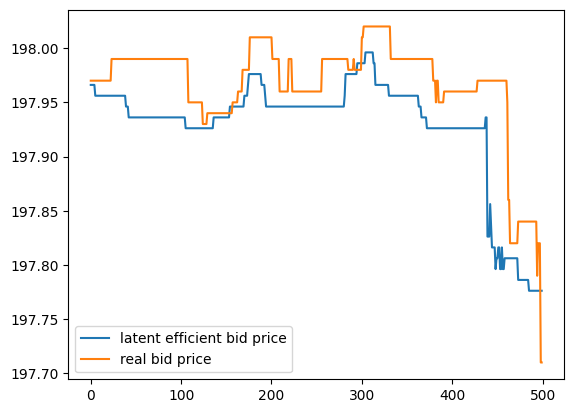

In [182]:
plt.plot((persistent_component_b_test)[j][0:500], label = "latent efficient bid price")
plt.plot((Y_test_b)[j][0:500], label = "real bid price")
plt.legend()
plt.show()

### Fit the Multinomial Logit Model

As outlined in the Methodology and Framework section, we assume that the return within the cluster of lagging price processes depends on the return of the leading bid/ask price process. To formalize this dependency, we model the (signed) return in the $j$-th cluster of the lagging bid price process—conditioned on the past $\mathcal{D} \in \mathbb{N}^{+}$ lagged returns from both the lagging and leading bid (or ask) price processes—as a Multinoulli-distributed random variable:

$$
\left( R_{C_{j}^{y^{(b)}}} ;\middle|; r_{C_{j-\mathcal{D}:j-1}^{y^{(b)}}},; r_{C_{j-\mathcal{D}+1:j}^{\widehat{y}^{(b)}}} \right)
\sim \text{Multinoulli}(p_{j,-1},; p_{j,0},; p_{j,+1}),
$$

where the outcome variable is defined by the sign of the total return in the cluster:
$R_{C_{j}^{y^{(b)}}} = \operatorname{sign}(r_{C_{j}^{y^{(b)}}})$
with $\operatorname{sign}(x) = +1$ if $x>0$, $-1$ if $x<0$, and $0$ if $x=0$.

---

The conditional class probabilities are:

$$
\begin{aligned}
p_{j,+1}^{(b)} &= \mathbb{P}!\left[ R_{C_{j}^{y^{(b)}}} = +1 ;\middle|; r_{C_{j-\mathcal{D}:j-1}^{y^{(b)}}},; r_{C_{j-\mathcal{D}+1:j}^{\widehat{y}^{(b)}}} \right], \
p_{j,-1}^{(b)} &= \mathbb{P}!\left[ R_{C_{j}^{y^{(b)}}} = -1 ;\middle|; r_{C_{j-\mathcal{D}:j-1}^{y^{(b)}}},; r_{C_{j-\mathcal{D}+1:j}^{\widehat{y}^{(b)}}} \right], \
p_{j,0}^{(b)}  &= \mathbb{P}!\left[ R_{C_{j}^{y^{(b)}}} = 0  ;\middle|; r_{C_{j-\mathcal{D}:j-1}^{y^{(b)}}},; r_{C_{j-\mathcal{D}+1:j}^{\widehat{y}^{(b)}}} \right].
\end{aligned}
$$

Here, $\text{Multinoulli}(p_{j,-1}^{(b)}, p_{j,0}^{(b)}, p_{j,+1}^{(b)})$ refers to a categorical distribution over three outcomes. It generalizes the Bernoulli distribution to more than two unordered classes, making it well-suited for modeling discrete probabilistic events when exactly one outcome is realized.

---

The linear predictors for the three classes at index $\mathcal{D} \leq j < T$ are:

$$
\begin{aligned}
\theta_{j,+1}^{(b)} &= \alpha_{+1}^{(b)} + \sum_{s=0}^{\mathcal{D}-1} \psi_{s,+1}^{(b)} r_{C_{j-s}^{\widehat{y}^{(b)}}}
	•	\sum_{s=1}^{\mathcal{D}} \gamma_{s,+1}^{(b)} r_{C_{j-s}^{y^{(b)}}} + \sum_{z=1}^{\mathcal{L}} \phi_{z,+1}^{(b)} \big(\widehat{y}{z}^{(b)} - y{z}^{(b)}\big), \
\theta_{j,-1}^{(b)} &= \alpha_{-1}^{(b)} + \sum_{s=0}^{\mathcal{D}-1} \psi_{s,-1}^{(b)} r_{C_{j-s}^{\widehat{y}^{(b)}}}
	•	\sum_{s=1}^{\mathcal{D}} \gamma_{s,-1}^{(b)} r_{C_{j-s}^{y^{(b)}}} + \sum_{z=1}^{\mathcal{L}} \phi_{z,-1}^{(b)} \big(\widehat{y}{z}^{(b)} - y{z}^{(b)}\big), \
\theta_{j,0}^{(b)}  &= \alpha_{0}^{(b)} + \sum_{s=0}^{\mathcal{D}-1} \psi_{s,0}^{(b)} r_{C_{j-s}^{\widehat{y}^{(b)}}}
	•	\sum_{s=1}^{\mathcal{D}} \gamma_{s,0}^{(b)} r_{C_{j-s}^{y^{(b)}}} + \sum_{z=1}^{\mathcal{L}} \phi_{z,0}^{(b)} \big(\widehat{y}{z}^{(b)} - y{z}^{(b)}\big).
\end{aligned}
$$

The final term in each predictor, $(\widehat{y}{j}^{(b)} - y{j}^{(b)})$, is not part of the model in Poutre (2024). We include it to capture predictive information in the difference between the latent efficient price and the observed price, as motivated by Section Testing the Common Trend Component.

---

Using the multinomial logit form, the class probabilities become:

$$
\begin{aligned}
p_{j,+1}^{(b)} &= \frac{e^{\theta_{j,+1}^{(b)}}}{1 + e^{\theta_{j,-1}^{(b)}} + e^{\theta_{j,+1}^{(b)}}}, \
p_{j,-1}^{(b)} &= \frac{e^{\theta_{j,-1}^{(b)}}}{1 + e^{\theta_{j,-1}^{(b)}} + e^{\theta_{j,+1}^{(b)}}}, \
p_{j,0}^{(b)}  &= \frac{1}{1 + e^{\theta_{j,-1}^{(b)}} + e^{\theta_{j,+1}^{(b)}}}.
\end{aligned}
$$

---

The parameters to be estimated, denoted by $\Theta^{(b)}$, can be obtained by maximum likelihood. Assuming the bid price series ${ y^{(b)}{j,t} }{t=1}^{T}$ consists of $\mathcal{N}$ return clusters, the likelihood is:

$$
\mathcal{L}(\Theta^{(b)}) ;=; \prod_{j=\mathcal{D}}^{\mathcal{N}}
\left(p_{j,+1}^{(b)}\right)^{\mathbf{1}{ R_{C_j^{y^{(b)}}} = +1 }}
\left(p_{j,-1}^{(b)}\right)^{\mathbf{1}{ R_{C_j^{y^{(b)}}} = -1 }}
\left(p_{j,0}^{(b)}\right)^{\mathbf{1}{ R_{C_j^{y^{(b)}}} = 0 }}.
$$

We estimate $\Theta^{(b)}$ using the Broyden–Fletcher–Goldfarb–Shanno (BFGS) algorithm, called by MNLogit under the hood.


In [183]:
# Only test bid series here
multionmial_logit_b = MultinomialLogit()

# Define leader and lagger series
# x is leading y
# Define train data
x_series_train_b = pd.Series(persistent_component_b_train[j])
y_series_train_b = pd.Series(Y_train_b[j])

# Define test data
x_series_test_b = pd.Series(persistent_component_b_test[j])
y_series_test_b = pd.Series(Y_test_b[j])

In [184]:
# Check if the max correlation occurs at a negative lag => x leads y
multionmial_logit_b.estimate_lead_lag_correlation(x_series_train_b, y_series_train_b, max_lag = 50), multionmial_logit_b.estimate_lead_lag_correlation(x_series_test_b, y_series_test_b, max_lag = 50)

(-14, -14)

In [185]:
# Get the data frame with cluster ids
cluster_df_train_b = multionmial_logit_b.compute_static_cluster_returns(x_series_train_b, y_series_train_b)
cluster_df_test_b = multionmial_logit_b.compute_static_cluster_returns(x_series_test_b, y_series_test_b)

In [186]:
# Generate the training data and fit the model with the train data we already have
# Lookback length for clusters
D = 20

X_train, y_train = multionmial_logit_b.generate_model_data(cluster_df_train_b, D)
X_test, y_test = multionmial_logit_b.generate_model_data(cluster_df_test_b, D)

model = multionmial_logit_b.fit(X_train, y_train)

In [187]:
# Check the performance

TP = FP = TN = FN = 0
# threshold K
K = 0.6

for i in range(len(X_test)):
    prediction = model.predict(X_test[i])[0]
    true_value = np.sign(y_test[i])

    # down prediction
   
    # up prediction
    if np.max(prediction) == prediction[2] and np.max(prediction) >= K:
        if true_value == +1:
            TP += 1
        else:
            FP += 1

    elif np.max(prediction) == prediction[0] and np.max(prediction) >= K:
        if true_value == -1:
            TN += 1
        else:
            FN += 1

    else:
        pass

In [188]:
TN, FN

(6, 6)

In [189]:
TP / (FP + TP), TN / (TN + FN)

(0.6666666666666666, 0.5)